In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.append("../../nansat/")
from nansat import Nansat

sys.path.append("../../..")
import sar

In [2]:
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub-archive.met.no" ,timeout=180)
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus", timeout=180)

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

# Open in situ data

In [5]:
##### read pickled imported in-situ measurements metadata with attached colocated Sentinel-1 sat products metadata
# (to avoid having to rerun the API search)
import pickle

with open('../../in_situ_obs.pickle', 'rb') as handle:
    in_situ_obs = pickle.load(handle)

with open('../../products_scihub.pickle', 'rb') as handle:
    products_scihub = pickle.load(handle)

In [6]:
in_situ_obs.keys()

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])

## Minimum epsilon to get at least 10 meters difference (size of a pixel)

Approx. 1e-4

In [7]:
10/111139

8.997741566866717e-05

# Examples

## 1)

### 1.a) Original image

In [8]:
buoy = 'Irminger_7'
fname = 'S1B_EW_GRDM_1SDH_20210728T201123_20210728T201223_027999_03571C_4E75.SAFE'
station_lat = in_situ_obs[buoy]['lat'][0]
station_lon = in_situ_obs[buoy]['lon'][0]

In [9]:
station_lat

59.9337

In [10]:
station_lon

-39.47378

In [11]:
n = Nansat(data_dir + fname)

In [12]:
import numpy as np
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/tmp/ipykernel_654935/1297138187.py:25: RuntimeWarning: divide by zero encountered in log10
  s0 = 10.*np.log10(s0)


/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


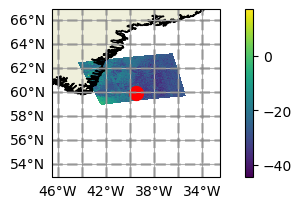

In [26]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=10,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 7, station_lon - 7, station_lat + 7, station_lon + 7
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

In [13]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [14]:
# Transform lonlat to xy
xy = n.transform_points(colVector=[station_lon], rowVector=[station_lat], DstToSrc=1)
xy

(array([4768.19062026]), array([1730.65128397]))

In [15]:
grid_lons[int(xy[1]), int(xy[0])]

-39.474621570608946

In [16]:
grid_lats[int(xy[1]), int(xy[0])]

59.93491721865447

#### Check sizes

Pixels ara not square.

In [17]:
n.get_pixelsize_meters()

(40.40691432447351, 39.91619958054399)

##### At first corner

In [18]:
grid_lons[0, 0] - grid_lons[0, 1]

-0.000669662097649848

In [19]:
grid_lats[0, 0] - grid_lats[0, 1]

-9.169757041149751e-05

##### Corner nr. 2

In [20]:
grid_lons[0, 0] - grid_lons[1, 0]

0.00019006012312416942

In [21]:
grid_lats[0, 0] - grid_lats[1, 0]

-0.000353786006861867

##### Corner nr. 3

In [22]:
grid_lons[-1, -1] - grid_lons[-1, -2]

0.0007869428133489009

In [23]:
grid_lats[-1, -1] - grid_lats[-1, -2]

5.512421371633991e-05

##### Corner nr. 4

In [24]:
grid_lons[-1, -1] - grid_lons[-2, -1]

-0.00011766836428961369

In [25]:
grid_lats[-1, -1] - grid_lats[-2, -1]

0.00035810982467410213

### 1.b) Crop 

The nansat method transform_points() does not works properly, it does not find the exact indices. I think the problem actually is in  gdal.Transformer TransformPoints, but I have not checked it.

In [211]:
xy = n.transform_points(colVector=[station_lon], rowVector=[station_lat], DstToSrc=1)
xy

(array([4768.19062026]), array([1730.65128397]))

In [212]:
int(xy[1])

1730

In [213]:
np.round(xy[1])

array([1731.])

Need to subtract 4 to the y index to get closer to the center

In [214]:
grid_lons[int(xy[1]) -4, int(xy[0])] - station_lon

-0.00023133180031464917

In [215]:
grid_lats[int(xy[1]) - 4, int(xy[0]) ] - station_lat

-0.00020621289429101353

In [216]:
grid_lons[int(xy[1]) - 4, int(xy[0])]

-39.47401133180031

In [217]:
grid_lats[int(xy[1]) - 4, int(xy[0])]

59.93349378710571

The following piece of code from one of Nils' files actually does the job. It has been implemented in sar.py

In [223]:
# Need to open again the image as cropping acts on the object n
n = Nansat(data_dir + fname)

In [224]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [225]:
# Find x and y in the image given station lat and lon 
a = abs( grid_lats - station_lat) + abs( grid_lons - station_lon)    
y, x= np.unravel_index(a.argmin(), a.shape)   

In [226]:
x

4768

In [227]:
y

1726

In [228]:
grid_lons[y, x] - station_lon

-0.00023133180031464917

In [229]:
grid_lats[y, x] - station_lat

-0.00020621289429101353

#### 1.b.i) Crop using indices computed with Nils' code (ROMS) 

In [230]:
# OBS: x, y
# The crop method uses the bottom-left corner as a reference. 
# We need to center it, and therefore we subtract i/2 to the offset.
n.crop(x -3, y-3, 8, 8, allow_larger=True)

(4765, 1723, 8, 8)

In [231]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [232]:
grid_lons

array([[-39.47565143, -39.47495218, -39.47425292, -39.47355366,
        -39.4728544 , -39.47215513, -39.47145586, -39.47075659],
       [-39.47580401, -39.47510475, -39.47440548, -39.47370621,
        -39.47300694, -39.47230767, -39.47160839, -39.47090911],
       [-39.47595659, -39.47525732, -39.47455804, -39.47385877,
        -39.47315949, -39.47246021, -39.47176092, -39.47106163],
       [-39.47610917, -39.47540989, -39.47471061, -39.47401132,
        -39.47331204, -39.47261275, -39.47191345, -39.47121415],
       [-39.47626175, -39.47556247, -39.47486318, -39.47416388,
        -39.47346459, -39.47276529, -39.47206598, -39.47136668],
       [-39.47641434, -39.47571504, -39.47501574, -39.47431644,
        -39.47361714, -39.47291783, -39.47221852, -39.4715192 ],
       [-39.47656692, -39.47586762, -39.47516831, -39.474469  ,
        -39.47376969, -39.47307037, -39.47237105, -39.47167173],
       [-39.47671951, -39.4760202 , -39.47532088, -39.47462157,
        -39.47392224, -39.4732229

In [233]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


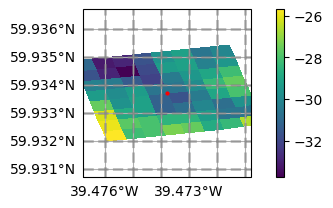

In [235]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=2,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

 Get a smaller image

In [236]:
n = Nansat(data_dir + fname)

In [237]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [238]:
a = abs( grid_lats - station_lat) + abs( grid_lons - station_lon)    
y, x= np.unravel_index(a.argmin(), a.shape)   

In [239]:
# OBS: x, y
n.crop(x -1, y-1, 4, 4, allow_larger=True)

(4767, 1725, 4, 4)

In [240]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [241]:
grid_lons

array([[-39.47455803, -39.47385876, -39.47315949, -39.47246022],
       [-39.47471059, -39.47401132, -39.47331204, -39.47261276],
       [-39.47486316, -39.47416387, -39.47346459, -39.4727653 ],
       [-39.47501572, -39.47431643, -39.47361714, -39.47291784]])

In [242]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


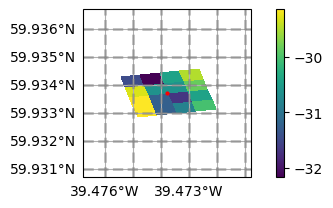

In [243]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=2,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

And smaller...

In [244]:
n = Nansat(data_dir + fname)

In [245]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [246]:
a = abs( grid_lats - station_lat) + abs( grid_lons - station_lon)    
y, x= np.unravel_index(a.argmin(), a.shape)   

In [247]:
# OBS: x, y
n.crop(x -1, y-1, 3, 3, allow_larger=True)

(4767, 1725, 3, 3)

In [248]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [249]:
grid_lons

array([[-39.47455804, -39.47385877, -39.47315949],
       [-39.4747106 , -39.47401132, -39.47331204],
       [-39.47486317, -39.47416388, -39.47346459]])

In [250]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


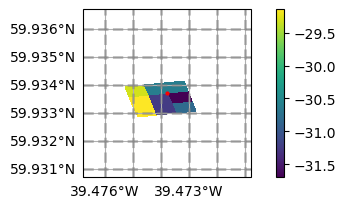

In [251]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=2,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

#### 1.b.i) Crop using the indices from nansat (does not work!)

We see that the station is not in the part of the image selected

In [152]:
n.crop(int(xy[0]), int(xy[1]), 3, 3, allow_larger=True)

(4768, 1730, 3, 3)

In [155]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [153]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


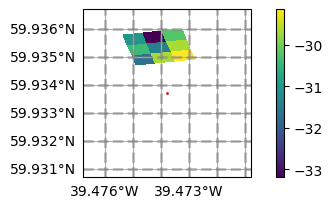

In [156]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

In [152]:
n.crop(int(xy[0]), int(xy[1]), 3, 3, allow_larger=True)

(4768, 1730, 3, 3)

In [155]:
grid_lons, grid_lats = n.get_geolocation_grids()

In [153]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


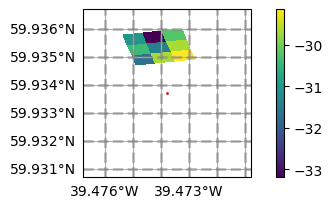

In [156]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

#### 1.c) Crop using the former method crop_sar_sata() in sar.py that calls crop_latlon() from nansat.

In [104]:
epsilon = 0.0005

In [105]:
lonlim=[station_lon - epsilon, station_lon + epsilon]
latlim=[station_lat - epsilon, station_lat + epsilon]

extent = n.crop_lonlat(lonlim=lonlim, latlim=latlim)

In [ ]:
s0, inc, az, pol = None, None, None, None
# Find band number of real valued HH or VV polarization NRCS
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
    
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Calculate VV polarization
if pol=='HH' and vv:
    s0 = calc_vv(s0, inc)

# NRCS in decibel
s0 = 10.*np.log10(s0)

In [ ]:
grid_lons, grid_lats = n.get_geolocation_grids()

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


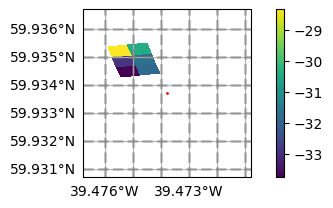

In [108]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

#### Same plot but setting image limits to lonlim and latlim

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


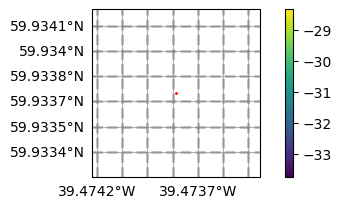

In [109]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = latlim[0], lonlim[0], latlim[-1], lonlim[-1]
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

#### Compare lonlim and latlim to the lats and lons in the cropped image

In [110]:
grid_lons

array([[-39.4751683 , -39.474469  ],
       [-39.47532087, -39.47462156],
       [-39.47547344, -39.47477412]])

In [112]:
lonlim

[-39.47428, -39.473279999999995]

In [113]:
grid_lats

array([[59.93448765, 59.93456136],
       [59.93484351, 59.93491722],
       [59.93519936, 59.93527308]])

In [114]:
latlim

[59.9332, 59.934200000000004]

In [115]:
n.get_pixelsize_meters()

(40.44641865752689, 39.78415944794485)

In [94]:
0.0005 * 111139

55.5695

In [15]:
s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + fname,
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=epsilon
)

In [17]:
s0

array([[-32.19700276, -30.3749069 ],
       [-31.36914996, -30.14327041],
       [-26.77566943, -28.86989013]])

In [18]:
grid_lons

array([[-39.4751683 , -39.474469  ],
       [-39.47532087, -39.47462156],
       [-39.47547344, -39.47477412]])

In [19]:
grid_lats

array([[59.93448765, 59.93456136],
       [59.93484351, 59.93491722],
       [59.93519936, 59.93527308]])

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


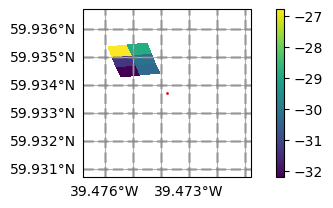

In [70]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.003, station_lon -0.003, station_lat + 0.003, station_lon + 0.003
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()

With another epsilon

In [71]:
epsilon = 0.005

In [72]:
s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + fname,
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=epsilon
)

In [80]:
s0.shape

(30, 20)

In [76]:
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


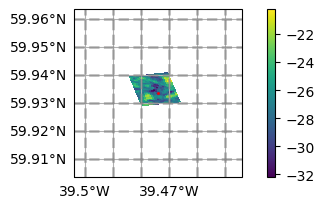

In [79]:
plt.figure()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

plt.pcolormesh(grid_lons, grid_lats, s0, transform=ccrs.PlateCarree(), axes=ax1)

plt.plot([station_lon], [station_lat],
         color='red',  marker='o', markersize=1,
         transform=ccrs.PlateCarree(),
         axes=ax1
         )
lat1, lon1, lat2, lon2 = station_lat - 0.03, station_lon -0.03, station_lat + 0.03, station_lon + 0.03
#lat1, lon1, lat2, lon2 = 58, -41, 61, - 38
#ax1.set_extent([lat1, lon1, lat2, lon2], crs=ccrs.PlateCarree())
ax1.set_xlim(lon1, lon2)
ax1.set_ylim(lat1, lat2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gridliner.Gridliner(axes=ax1, crs=ccrs.PlateCarree(), draw_labels=True)

plt.colorbar()